In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [10]:
from pathlib import Path

IMAGES_PATH = Path() / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# SVM

### Linear SVM

In [3]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 2) # Iris virginica
svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [4]:
X_new = [[5.5, 1.7], [5.0, 1.5]]

svm_clf.predict(X_new) # True, False

array([ True, False])

In [5]:
svm_clf.decision_function(X_new) # notice the range [-1, 1]

array([ 0.66163816, -0.22035761])

### Nonlinear SVM

In [6]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

In [12]:
# Using kernel trick instead of PolynomialFeatures transformer
# The hyperparameter coef0 controls how much the model is influenced by high-degree terms versus low-degree terms.
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [13]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

# Exercises

1. To create a boundary line with the widest possible margin by selecting a few instances with non-zero features that will help determine where the line is placed
2. A support vector is an instance that is hardest to classify and so helps determine where the boundary line is placed
3. Instances need standardized features to correctly calculate the distance from the boundary line or else small values will be ignored
4. Use the `decision_function` to compute confidence scores. The scores represent distance from the boundary line NOT class probability. You can set `probability=True` on the `SVC` constructor to get a probability score using the `predict_proba` method
5. `LinearSVC` for binary classification, `SVC` for multiple classes & kernel-trick support, and `SGDClassifier` for large datasets
6. Increase gamma. Decreasing C regularizes the model, so this might also be increased
7. In regression, adding more training instances to the margin doesn't affect the model's predictions, therefore it is epsilon insensitive
8. To compute features in a higher dimensional space without having to do explicit computations

### 9

In [32]:
iris = load_iris(as_frame=True)
X_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
y_iris = iris.target

In [33]:
print(iris.target_names)
setosa_or_versicolor = (y_iris == 0) | (y_iris == 1)

X_iris = X_iris[setosa_or_versicolor]
y_iris = y_iris[setosa_or_versicolor]

['setosa' 'versicolor' 'virginica']



1. LinearSVC uses loss="squared_hinge" by default, so if we want all 3 models to produce similar results, we need to set loss="hinge".
2. SVC uses an RBF kernel by default, so we need to set kernel="linear" to get similar results as the other two models.
3. SGDClassifier class does not have a C hyperparameter, but it has another regularization hyperparameter called alpha, so we can tweak it to get similar results as the other two models.


In [34]:
from sklearn.linear_model import SGDClassifier

std_scaler = StandardScaler()
X_iris_scaled = std_scaler.fit_transform(X_iris)

C = 5
alpha = 0.05

iris_lin_svc = LinearSVC(loss='hinge', C=C, dual=True, random_state=42).fit(X_iris_scaled, y_iris)
iris_svc = SVC(kernel='linear', C=C).fit(X_iris_scaled, y_iris)
iris_sgd = SGDClassifier(alpha=alpha, random_state=42).fit(X_iris_scaled, y_iris)

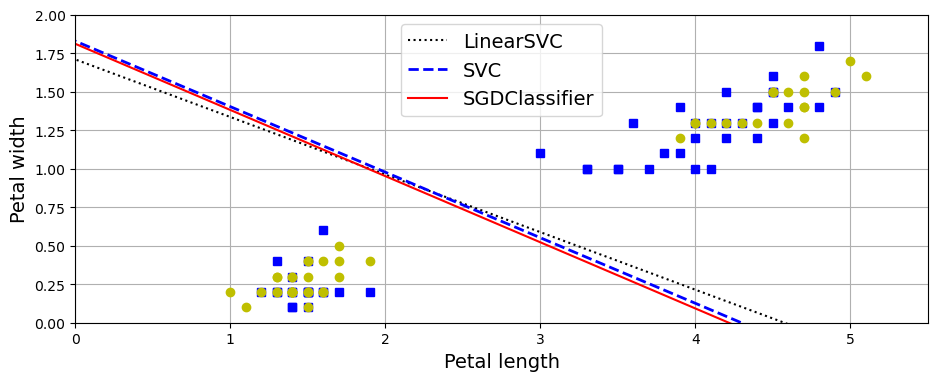

In [36]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return std_scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(iris_lin_svc)
svc_line = compute_decision_boundary(iris_svc)
sgd_line = compute_decision_boundary(iris_sgd)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X_iris[:, 0][y==1], X_iris[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X_iris[:, 0][y==0], X_iris[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis((0, 5.5, 0, 2))
plt.grid()

plt.show()

### 10

In [40]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [41]:
from sklearn.model_selection import train_test_split

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine.data, wine.target, random_state=42)

In [42]:
X_wine_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [47]:
from sklearn.model_selection import cross_val_score

wine_pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=42))
cross_val_score(wine_pipeline, X_wine_train, y_wine_train, cv=3, scoring="accuracy")

array([0.97777778, 0.97727273, 0.97727273])

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__C': [1, 2.5, 5, 10],
    'svc__gamma': [0.01, 0.005, 0.001, 0.0005]
}

wine_pipeline = make_pipeline(StandardScaler(), SVC())

wine_grid_search = GridSearchCV(wine_pipeline, param_grid, cv=3, scoring='accuracy')
wine_grid_search.fit(X_wine_train, y_wine_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 2.5, 5, 10],
                         'svc__gamma': [0.01, 0.005, 0.001, 0.0005]},
             scoring='accuracy')

In [50]:
print(wine_grid_search.best_params_)

cv_res = pd.DataFrame(wine_grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res.head(5)

{'svc__C': 5, 'svc__gamma': 0.01}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.001192,0.000062,0.000753,0.000068,5.0,0.010,"{'svc__C': 5, 'svc__gamma': 0.01}",1.000000,0.977273,0.977273,0.984848,0.010714,1
13,0.001124,0.000057,0.000725,0.000033,10.0,0.005,"{'svc__C': 10, 'svc__gamma': 0.005}",1.000000,0.977273,0.977273,0.984848,0.010714,1
1,0.001870,0.000701,0.001050,0.000312,1.0,0.005,"{'svc__C': 1, 'svc__gamma': 0.005}",0.977778,0.977273,0.977273,0.977441,0.000238,3
4,0.001476,0.000436,0.000788,0.000017,2.5,0.010,"{'svc__C': 2.5, 'svc__gamma': 0.01}",0.977778,0.977273,0.977273,0.977441,0.000238,3
5,0.001141,0.000034,0.000718,0.000009,2.5,0.005,"{'svc__C': 2.5, 'svc__gamma': 0.005}",0.955556,0.977273,0.977273,0.970034,0.010238,5


In [51]:
wine_grid_search.score(X_wine_test, y_wine_test)

0.9777777777777777

### 11

In [2]:
from sklearn.datasets import fetch_california_housing
from pathlib import Path

DATA_PATH = Path() / 'datasets'
DATA_PATH.mkdir(parents=True, exist_ok=True)

def load_housing_data():
    data = fetch_california_housing(data_home=DATA_PATH, as_frame=True)
    
    return data

housing = load_housing_data()

In [15]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [19]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2, random_state=42)

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

housing_svr = make_pipeline(StandardScaler(), LinearSVR(epsilon=0.0, max_iter=5000, random_state=42))
housing_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

In [38]:
from sklearn.metrics import root_mean_squared_error

y_pred = housing_svr.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)

print(rmse)

0.9795654478293887


In [39]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distribs = {
    'svr__gamma': loguniform(0.001, 0.1),
    'svr__C': uniform(1, 10)
}

housing_svr = make_pipeline(StandardScaler(), SVR())
random_search = RandomizedSearchCV(housing_svr, param_distributions=param_distribs, cv=3,
                           n_iter=1000, random_state=42)
random_search.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=1000,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1632611d0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1625e8c20>},
                   random_state=42)

In [41]:
random_search.best_params_

{'svr__C': np.float64(7.169269183757422),
 'svr__gamma': np.float64(0.09170063774757269)}

In [43]:
from sklearn.model_selection import cross_val_score

-cross_val_score(random_search.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58291831, 0.5677818 , 0.5744682 , 0.56512787, 0.5917189 ])

In [44]:
y_pred = random_search.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

0.5822620414755879